# Εργασία Αναλυτικής Δεδομένων 2024
---
### Βήμα 1: Προεπεξεργασία Δεδομένων

In [431]:
from unittest.mock import inplace

import numpy as np
import pandas as pd

import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB


#### Ρυθμίσεις


In [432]:
pd.options.mode.copy_on_write = True

---

### Ανάγνωση Βάσης Δεδομένων
#### Όνομα: Bank Marketing Data Set (https://archive.ics.uci.edu/dataset/222/bank+marketing)

In [433]:
data = pd.read_csv('bank-full.csv', sep=';')

#### Πρώτη γνωριμία με τα Δεδομένα

In [434]:
# data

#### Μέγεθος και Δομή Δεδομένων

In [435]:
data.shape

(45211, 17)

In [436]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [437]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [438]:
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


#### Διαγραφή Διπλότυπων

In [439]:
data_no_dupes = data.drop_duplicates()
data_no_dupes.shape

(45211, 17)

---

### Εύρεση και Αντιμετώπιση Ακραίων τιμών
Η αναζήτηση ακραίων τιμών έχει νόημα μόνο στα αριθμητικά χαρακτηριστικά ('age', 'balance', 'day', 'duration', 'campaign'). Οι στήλες pdays και previous λόγω των τιμών και της σημασίας τους, θα έχουν διαφορετική μεταχείριση στη συνέχεια.
Χρησιμοποιείται η μέθοδος IQR.

#### Διαχωρισμός των αριθμητικών χαρακτηριστικών σε δύο ομάδες (age, balance, day, duration, campaign) και (pdays,previous)


In [440]:
numeric_columns_part = data_no_dupes[["age", "balance", "day", "duration", "campaign"]]

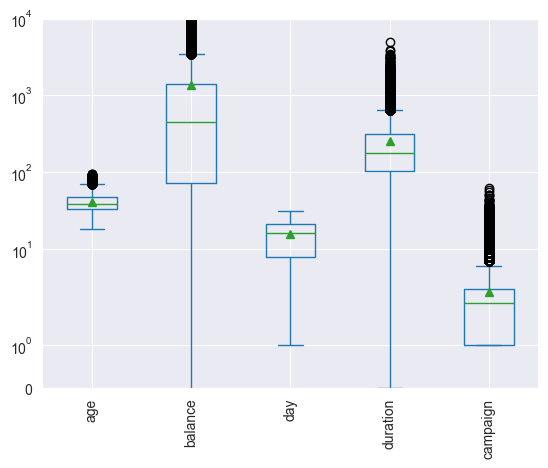

In [441]:
fig, ax = plt.subplots(1,1)

numeric_columns_part.plot.box(ax=ax, rot=90, showmeans=True)

ax.set_ylim(0, 10000)
ax.set_yscale('symlog')

#### Εκκαθάριση ακραίων τιμών


In [442]:
def clean_outliers(data, numeric_columns_part):

        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = numeric_columns_part.quantile(0.25)
        Q3 = numeric_columns_part.quantile(0.75)

        # Calculate IQR (Inter-quantile Range)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows where outliers exist for the current column
        no_outliers_mask = ((numeric_columns_part >= lower_bound) & (numeric_columns_part <= upper_bound)).all(axis=1)
        cleaned_df = data[no_outliers_mask]
        
        return cleaned_df

In [443]:
data_no_outliers = clean_outliers(data_no_dupes, numeric_columns_part)
numeric_columns_part = data_no_outliers[["age", "balance", "day", "duration", "campaign"]]

#### Έλεγχος αφαίρεσης ακραίων τιμών


In [444]:
data_no_outliers.shape

(34719, 17)

In [445]:
numeric_columns_part.describe()

,age,balance,day,duration,campaign
count,34719.000000,34719.000000,34719.000000,34719.000000,34719.000000
mean,40.276275,633.803681,15.474092,207.006941,2.132262
std,9.924791,839.361046,8.312784,139.454578,1.320066
min,18.000000,-1944.000000,1.000000,0.000000,1.000000
25%,32.000000,46.000000,8.000000,102.000000,1.000000
50%,39.000000,344.000000,15.000000,171.000000,2.000000
75%,48.000000,967.000000,21.000000,280.000000,3.000000
max,70.000000,3462.000000,31.000000,643.000000,6.000000


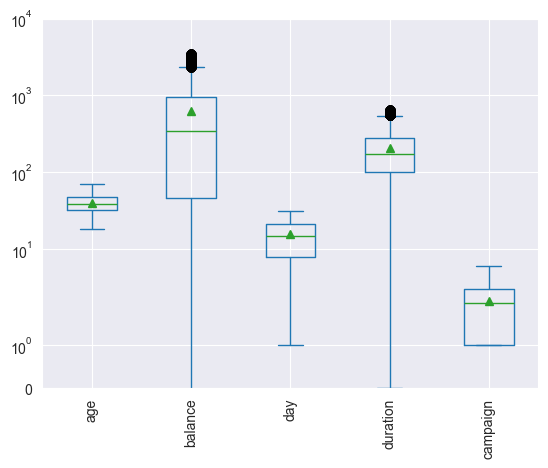

In [446]:
fig, ax = plt.subplots(1,1)

numeric_columns_part.plot.box(ax=ax, rot=90, showmeans=True)

ax.set_ylim(0, 10000)
ax.set_yscale('symlog')

#### Αντιμετώπιση αριθμητικών χαρακτηριστικών (pdays, previous)
#### Το χαρακτηριστικό `previous` εκφράζει εάν έχει γίνει προηγούμενη επικοινωνία με τον πελάτη πριν από αυτή την καμπάνια και πόσες φορές. Αφού καθαριστούν οι ακραίες τιμές, για τις ανάγκες της μελέτης μας θα μετατραπεί σε boolean data type, όπου `0` (δεν έχει υπάρξει προηγούμενη επικοινωνία) θα είναι `False` και τιμές `>0` (έχει υπάρξει προηγούμενη επικοινωνία) θα είναι `True`

Text(0, 0.5, 'Customers')

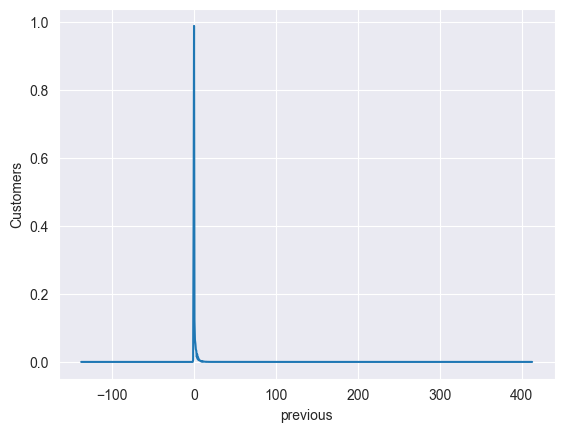

In [447]:
fig, ax = plt.subplots(1,1)

data_no_outliers.previous.plot.density(ax=ax)
ax.set_xlabel('previous')
ax.set_ylabel('Customers')

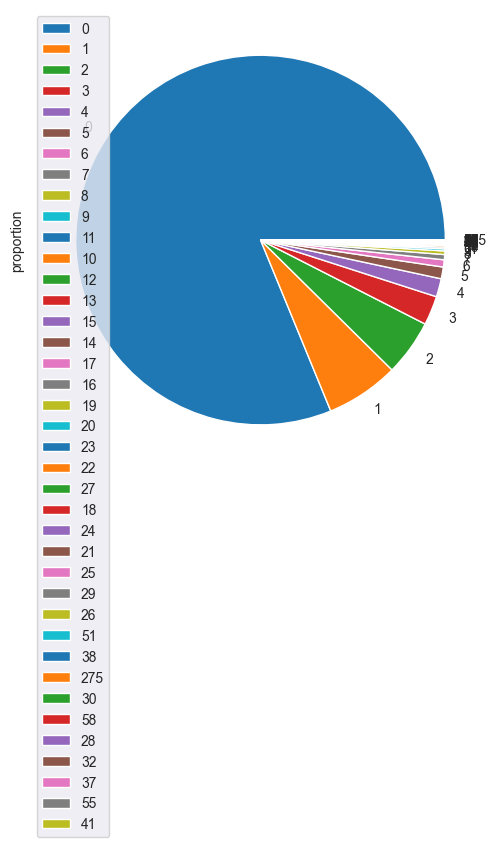

In [448]:
out = data_no_outliers.previous.value_counts(sort=True, normalize=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
out.plot.pie(legend=True, ax=ax)
plt.show()


#### Η τιμή 275 είναι ξεκάθαρα outlier και θα αφαιρεθεί η αντίστοιχη εγγραφή

np.int64(275)

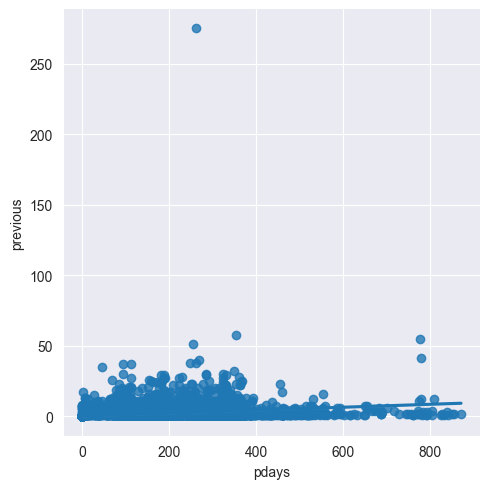

In [449]:
sns.lmplot(x="pdays", y="previous", data=data_no_dupes )
data_no_dupes.previous.max()

In [450]:
clean_data = data_no_outliers[data_no_outliers['previous'] != 275]
clean_data.shape

(34718, 17)

#### Μετατροπή σε boolean τιμή
Αρχικά όλες οι τιμές από >1 θα γίνουν 1, έτσι ώστε η στήλη να περιέχει μόνο 1 και 0. Μετά θα μετασχηματιστεί σε boolean.


In [451]:
clean_data.loc[clean_data.previous > 1, 'previous'] = 1
clean_data.previous.describe()

count    34718.000000
mean         0.187943
std          0.390672
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: previous, dtype: float64

In [452]:
clean_data.previous = clean_data.previous.astype('bool')
clean_data.previous.describe()

count     34718
unique        2
top       False
freq      28193
Name: previous, dtype: object

### [pdays shenanigans]

#### Διαμόρφωση boolean χαρακτηριστικών

In [453]:
boolean_columns = clean_data[['default', 'housing', 'loan', 'y']]
boolean_columns.head()

,default,housing,loan,y
0,no,yes,no,no
1,no,yes,no,no
2,no,yes,yes,no
3,no,yes,no,no
4,no,no,no,no


In [454]:
boolean_columns.dtypes

default    object
housing    object
loan       object
y          object
dtype: object

In [455]:
boolean_columns.default.unique()

array(['no', 'yes'], dtype=object)

#### Τα χαρακτηριστικά boolean δεν είναι ακόμα τύπου boolean, οπότε πιο κάτω θα μετασχηματιστούν.

In [456]:
clean_data['default'] = clean_data['default'].map({'yes': 1, 'no': 0})
clean_data['housing'] = clean_data['housing'].map({'yes': 1, 'no': 0})
clean_data['loan'] = clean_data['loan'].map({'yes': 1, 'no': 0})
clean_data['y'] = clean_data['y'].map({'yes': 1, 'no': 0})
clean_data.default = clean_data.default.astype('bool')
clean_data.housing = clean_data.housing.astype('bool')
clean_data.loan = clean_data.loan.astype('bool')
clean_data.y = clean_data.y.astype('bool')

In [457]:
clean_data[['default', 'housing', 'loan', 'y']].describe()

,default,housing,loan,y
count,34718,34718,34718,34718
unique,2,2,2,2
top,False,True,False,False
freq,34042,19841,28792,31817


#### Διαχείριση Κατηγορικών Χαρακτηριστικών

In [458]:
categorical_columns = clean_data[['job', 'education', 'contact','poutcome']]
categorical_columns.head()

,job,education,contact,poutcome
0,management,tertiary,unknown,unknown
1,technician,secondary,unknown,unknown
2,entrepreneur,secondary,unknown,unknown
3,blue-collar,unknown,unknown,unknown
4,unknown,unknown,unknown,unknown


In [459]:
categorical_columns.describe()

,job,education,contact,poutcome
count,34718,34718,34718,34718
unique,12,4,3,4
top,blue-collar,secondary,cellular,unknown
freq,7705,18378,22524,28197


#### Βάση των πληροφοριών που παρέχονται από την πηγή τα δεδομένα δεν περιέχουν τιμές NaN (null). Ωστόσο υπάρχουν τιμές σε κατηγορικά χαρακτηριστικά ('unknown' ή 'other') που δηλώνουν την έλλειψη πληροφορίας. Ποιο κάτω θα υπολογιστεί το πλήθος των τιμών αυτών για κάθε κατηγορικό χαρακτηριστικό και θα γίνει μία γραφική απεικόνιση, ώστε να προσδιοριστεί η κατάλληλη προσέγγιση στη συμπλήρωση τους

In [460]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Αριθμός τιμών "unknown"

In [461]:
categorical_columns[(categorical_columns=='unknown')].count()

job            198
education     1356
contact      10283
poutcome     28197
dtype: int64

#### Γραφική Αναπαράσταση Ελλιπών τιμών ανά Χαρακτηριστικό

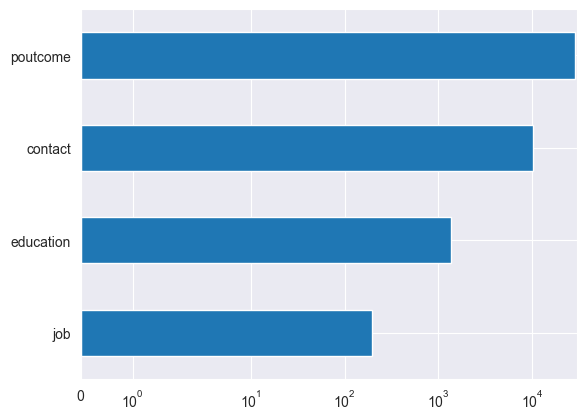

In [462]:
fig, ax = plt.subplots(1,1)
categorical_columns[(categorical_columns=='unknown')].count().plot.barh(ax=ax)

ax.set_xscale('symlog')

#### Ποσοστό εμφάνισης τιμών "unknown" για κάθε κατηγορικό χαρακτηριστικό

In [463]:
categorical_columns[(categorical_columns=='unknown')].count()*100/len(data_no_dupes)

job           0.437947
education     2.999270
contact      22.744465
poutcome     62.367565
dtype: float64

Η στήλη **poutcome** έχει υπερβολικά πολλές τιμές `unknown` (81.7%). Επειδή λείπει υπερβολικά μεγάλο ποσοστό πληροφορίας, αυτή η στήλη θα αφαιρεθεί.

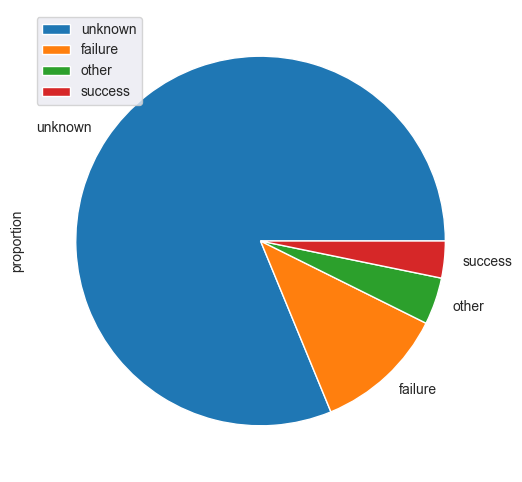

In [464]:
out = clean_data.poutcome.value_counts(sort=True, normalize=True)

fig, ax = plt.subplots(1,1, figsize=(6,6))
out.plot.pie(legend=True, ax=ax)
plt.show()

In [465]:
clean_data = clean_data.drop(columns=['poutcome'], axis=1)
clean_data.columns 

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'y'],
      dtype='object')

#### Συμπλήρωση ελλιπών τιμών (job, education)
Στα χαρακτηριστικά **'job'** και **'education'** επειδή το ποσοστό των ελλιπών τιμών είναι μικρό (0.63% και 4.1% αντίστοιχα) και άρα δεν θα είχε ισχυρή επιρροή στη μέση τιμή οι ελλιπείς τιμές θα συμπληρωθούν με την μέση τιμή (most frequent value) του αντίστοιχου χαρακτηριστικού.

In [466]:
# Calculate the mode of the 'job' column
job_mode = clean_data['job'].mode()[0]

# Replace 'unknown' values in the 'job' column with the mode
# filled_categorical_columns = categorical_columns.copy()
clean_data['job'] = clean_data['job'].replace('unknown',job_mode)

# Check
clean_data[clean_data['job']=='unknown']['job'].count()

np.int64(0)

In [467]:
# Calculate the mod of the 'education' column
education_mode = clean_data['education'].mode()[0]

# Replace 'unknown' values in the 'education' column with the mode
clean_data['education'] = clean_data['education'].replace('unknown',education_mode)

# Check
clean_data[clean_data['education']=='unknown']['education'].count()

np.int64(0)

#### contact
Το χαρακτηριστικό **'contact'** έχει ένα σημαντικό ποσοστό (28.79%) ελλιπών τιμών τα οποία αν συμπληρωθούν με την ποιο συχνή τιμή μπορεί τελικά το χαρακτηριστικό να μην αντιπροσωπεύει την πραγματικότητα. Για αυτό το λόγο θα χρησιμοποιηθούν οι πληροφορίες που παρέχουν τα υπόλοιπα χαρακτηριστικά μέσω ενός Bayesian Ταξινομητή ,που θα εκπαιδευτεί στις πλήρεις γραμμές της βάσης δεδομένων για να συμπληρώσει αυτές με τις ελλειπείς τιμές.

In [468]:
clean_data.contact.value_counts(sort=False)

contact
unknown      10283
cellular     22524
telephone     1911
Name: count, dtype: int64

In [469]:
clean_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,False,2143,True,False,unknown,5,may,261,1,-1,False,False
1,44,technician,single,secondary,False,29,True,False,unknown,5,may,151,1,-1,False,False
2,33,entrepreneur,married,secondary,False,2,True,True,unknown,5,may,76,1,-1,False,False
3,47,blue-collar,married,secondary,False,1506,True,False,unknown,5,may,92,1,-1,False,False
4,33,blue-collar,single,secondary,False,1,False,False,unknown,5,may,198,1,-1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,34,admin.,single,secondary,False,557,False,False,cellular,17,nov,224,1,-1,False,True
45203,23,student,single,tertiary,False,113,False,False,cellular,17,nov,266,1,-1,False,True
45205,25,technician,single,secondary,False,505,False,True,cellular,17,nov,386,2,-1,False,True
45209,57,blue-collar,married,secondary,False,668,False,False,telephone,17,nov,508,4,-1,False,False


In [473]:
clean_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
45202,34,admin.,single,secondary,False,557,False,False,cellular,17,nov,224,1,-1,False,True
45203,23,student,single,tertiary,False,113,False,False,cellular,17,nov,266,1,-1,False,True
45205,25,technician,single,secondary,False,505,False,True,cellular,17,nov,386,2,-1,False,True
45209,57,blue-collar,married,secondary,False,668,False,False,telephone,17,nov,508,4,-1,False,False
45210,37,entrepreneur,married,secondary,False,2971,False,False,cellular,17,nov,361,2,188,True,False


In [471]:

# # Replace 'unknown' with NaN for simplicity
df['contact'] = clean_data['contact'].map({'unknown': np.nan})

# clean_data['contact'] = clean_data['contact'].replace('unknown', np.nan, inplace=True)


In [472]:


df_copy = clean_data[['age','balance','contact']].dropna()
df_copy['contact']=df_copy['contact'].map({'cellular':1, 'telephone':2})

X = df_copy[['age','balance']].to_numpy()
Y = df_copy['contact'].to_numpy()

clf = GaussianNB()
clf.fit(X,Y)

nan_rows = clean_data[clean_data['contact'].isna()]
X_nan = nan_rows[['age','balance']].to_numpy()

# Find missing values
predicted_values = clf.predict(X_nan)
predicted_values = pd.DataFrame(predicted_values, columns=['contact'])

predicted_values['contact'] = predicted_values['contact'].map({1: 'cellular', 2: 'telephone'})

clean_data.loc[clean_data['contact'].isna(), 'contact'] = predicted_values

ValueError: Input y contains NaN.

#### Βασικά Στατιστικά Στοιχεία

In [35]:
numeric_columns.describe().round(2)

NameError: name 'numeric_columns' is not defined

In [533]:
(numeric_columns['balance'] < 0).sum()*100/len(data_no_dupes)

np.float64(8.329831235761208)

In [534]:
n = numeric_columns[(numeric_columns['balance']<0)].describe()
n.balance

count    3766.000000
mean     -317.677642
std       368.994983
min     -8019.000000
25%      -422.000000
50%      -230.000000
75%       -93.000000
max        -1.000000
Name: balance, dtype: float64

#### Κανονικοποίηση

In [538]:
X = numeric_columns.to_numpy()
transformer = RobustScaler().fit(X)
normalized_X =transformer.transform(X)


In [539]:
clean_numerical_columns = pd.DataFrame(normalized_X, columns=numeric_columns.columns)
clean_numerical_columns

KeyboardInterrupt: 

#### Ποσοστό επιτυχίας σε αυτή τη Marketing Καμπάνια 

In [180]:
boolean_columns[['y']].sum()*100/len(data_no_dupes)

y    11.69848
dtype: float64

---
#### Μείωση Διαστάσεων

##### Correlation heatmap

<Axes: >

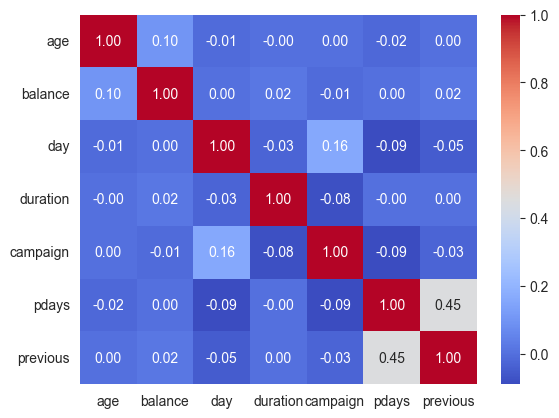

In [181]:
correlation_matrix = numeric_columns.corr().round(2)
correlation_matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True,  fmt='.2f')

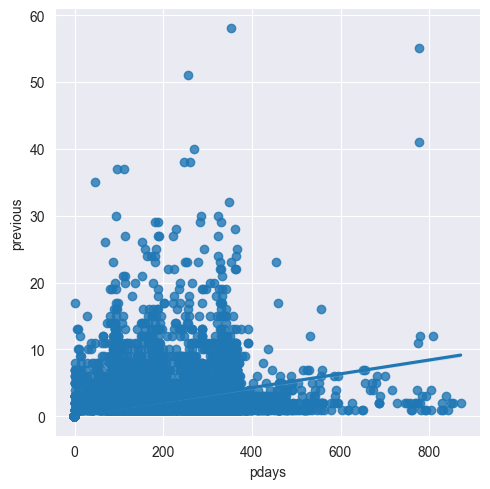

In [182]:
i = numeric_columns[(numeric_columns.previous == numeric_columns.previous.max())].index
numeric_columns.drop(i)
sns.lmplot(x="pdays", y="previous", data=numeric_columns.drop(i), )

clean_database =  pd.concat([clean_numerical_columns, boolean_columns, filled_categorical_columns])

### Cell jail

In [223]:
numeric_columns = data_no_dupes.select_dtypes(include=['number'])
numeric_columns.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


In [229]:
fig, ax = plt.subplots(1,1)

numeric_columns.pdays.plot.density(ax=ax)
ax.set_xlabel('pdays')
ax.set_ylabel('Customers')

Text(0, 0.5, 'Customers')

Error in callback <function flush_figures at 0x000001D9711C0EA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [169]:

# outliers = numeric_columns[~numeric_columns.index.isin(clean_numeric_columns.index)]
# #outliers = clean_numeric_columns

# fig, ax = plt.subplots(1,1)

# numeric_columns.plot.scatter(x='age',y='balance',ax=ax)
# # Overlay outliers as red dots on the x-axis
# # plt.scatter(outliers['balance'], np.zeros_like(outliers['balance']), color='red', marker='o', label='Outliers', zorder=5)
# outliers.plot.scatter(x='age', y='balance',color='red', marker='o', label='Outliers', zorder=5)

# ax.set_xlabel('Age')
# ax.set_ylabel('Balance ($)')

# fig, ax = plt.subplots(1,1)

# clean_numeric_columns.plot.box(ax=ax, rot=90, showmeans=True)

# ax.set_ylim(0, 10000)
# ax.set_yscale('symlog')